# <center>Organizaci&oacute;n de Datos</center>
#### <center>C&aacute;tedra Ing. Rodriguez, Juan Manuel </center>

## <center>Métodos de Agrupamiento</center>
### <center> Práctica K means </center>

#### Links interesantes
 * scikit-learn.org/stable
 * pandas.pydata.org
 * scikit-yb.org
 * matplotlib.org
 * seaborn.pydata.org


Importamos librerías generales

In [ ]:
#Librerías para manejo de datos
import pandas as pd
import numpy as np

#Librerías para gráficos
import matplotlib.pyplot as plt
import seaborn as sns

#Otras librerías
import os
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

Importamos librerías de modelos

In [ ]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.cluster import KMeans

#### Introducción

Algoritmo de aprendizaje no supervisado <br> 
Agrupa observaciones para un número predefinido de grupos  <br>
El centro de cada grupo es la media aritmética de todas las observaciones pertenecientes a ese grupo  <br>
Cada observación está más cerca del centro de su grupo que de cualquier centro de otro grupo  <br>

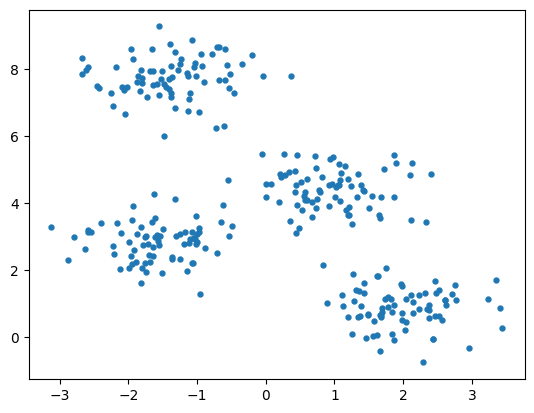

In [ ]:
from sklearn.datasets import make_blobs

#Generamos un dataset sintético
x_ejemplo1, y_ejemplo1 = make_blobs(n_samples=300, centers=4,
                       cluster_std=0.60, random_state=0)
plt.scatter(x_ejemplo1[:, 0], x_ejemplo1[:, 1], s=50,marker='.')
plt.show()

A priori, podemos ver fácilmente que estos datos se podrían separar en grupos <br>
Luego vamos a formalizar cómo hacer esto!


Para entrenar un cluster k-means, debemos importar KMeans del módulo sklearn.cluster.

Este algoritmo posee diferentes hiper-parámetros que se pueden configurar:

* init: es el método de inicialización de los centroides. En este caso definimos random para que se seleccionen aleatoriamente los puntos.

* n_clusters: definine la cantidad N de clústers que queremos como resultado.

* random_state: es la semilla de la aleatorización.

In [ ]:
kmeans = KMeans(n_clusters=4)  #Creamos un objeto de la clase KMeans para realizar el agrupamiento

kmeans.fit(x_ejemplo1) #Entrenamos el algoritmo para que aprenda cómo agrupar

y_kmeans = kmeans.predict(x_ejemplo1)

Visualicemos los grupos y el centroide de cada uno

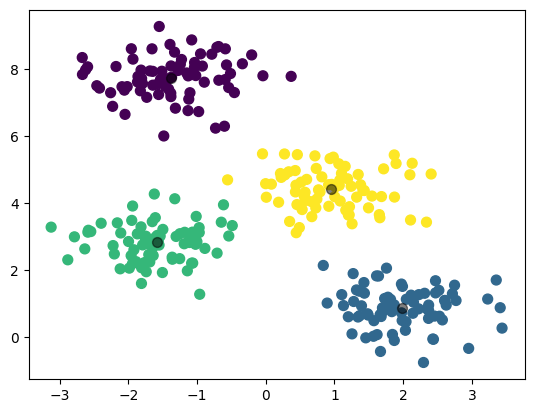

In [ ]:
plt.scatter(x_ejemplo1[:, 0], x_ejemplo1[:, 1], c=y_kmeans, s=50, cmap='viridis')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5,marker='.')
plt.show()

Implementemos nuestro propio kmeans

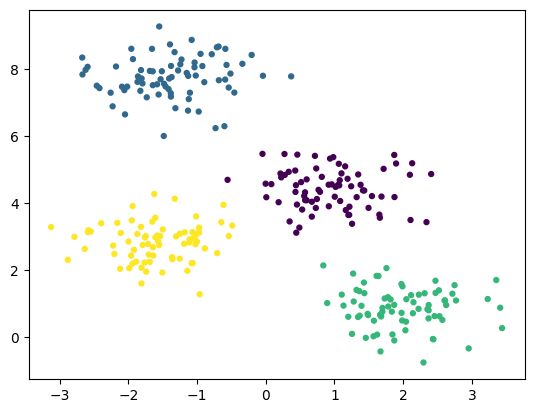

In [ ]:
from sklearn.metrics import pairwise_distances_argmin

def nuestro_kmeans(X, n_clusters, rseed=2):
    # 1. Elegimos los grupos random
    rng = np.random.RandomState(rseed)
    i = rng.permutation(X.shape[0])[:n_clusters]    
    centroides = X[i]
    
    cambien_centroides=True
    while cambien_centroides:
        # 2. Asignamos grupos en función de la distancia al centroide más cercano
        labels = pairwise_distances_argmin(X, centroides)
        
        # 3. Enconramos nuevos centroideas en función de la media de las observaciones en cada cluster
        nuevos_centroides = np.array([X[labels == i].mean(0)
                                for i in range(n_clusters)])
        
        # 4. Verificamos si los centroides cambiaron con respecto a la iteración anterior
        if np.all(centroides == nuevos_centroides):
            cambien_centroides=False
        centroides = nuevos_centroides
    
    return centroides, labels

centroides, labels = nuestro_kmeans(x_ejemplo1, 4)
plt.scatter(x_ejemplo1[:, 0], x_ejemplo1[:, 1], c=labels,
            s=50, cmap='viridis',marker='.')
plt.show()

Este algoritmo tiene la particularidad de poder no llegar al mejor resultado. <br>
Como la inicialización es al azar, de cambiar la semilla de generación, los grupos formados podrían ser distintos

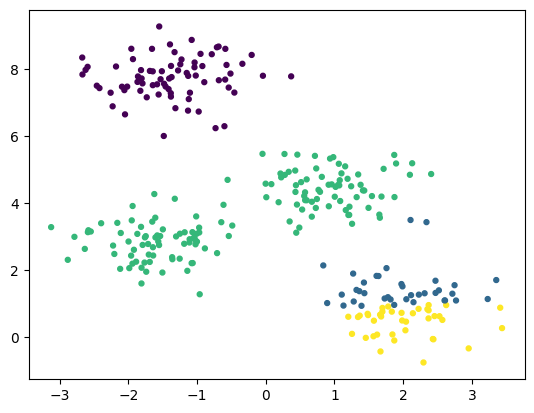

In [ ]:
centers, labels = nuestro_kmeans(x_ejemplo1, 4, rseed=0)
plt.scatter(x_ejemplo1[:, 0], x_ejemplo1[:, 1], c=labels,
            s=50, cmap='viridis',marker='.')
plt.show()

La cantidad de grupos (clusters) deben ser definidos antes de ejecutar el método. <br>
Probemos que pasa si buscamos 6 clusters

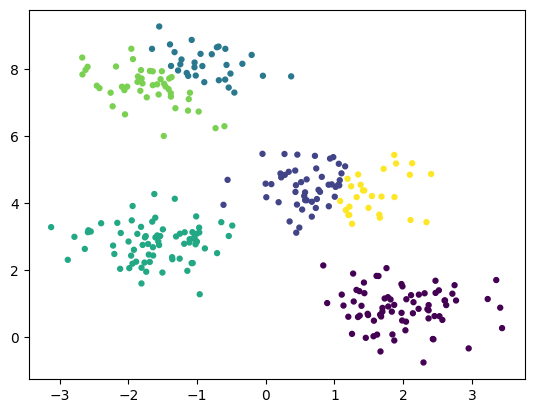

In [ ]:
labels = KMeans(6, random_state=0).fit_predict(x_ejemplo1)
plt.scatter(x_ejemplo1[:, 0], x_ejemplo1[:, 1], c=labels,
            s=50, cmap='viridis',marker=".")
plt.show()

k-means tiende a conseguir fronteras circulares para los grupos
Esto puede ser un problema con formas más complicadas

Por ejemplo veamos el siguiente ejemplo

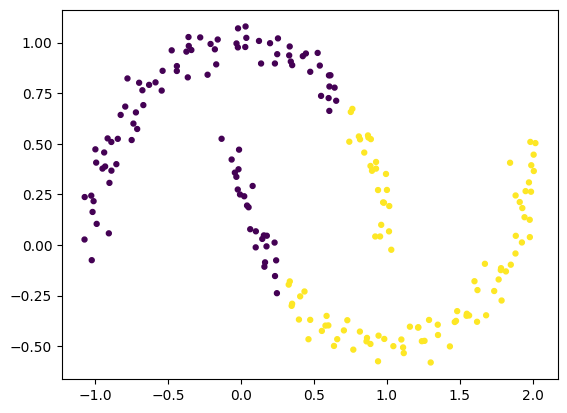

In [ ]:
from sklearn.datasets import make_moons
X, y = make_moons(200, noise=.05, random_state=0)

labels = KMeans(2, random_state=0).fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels,
            s=50, cmap='viridis',marker='.')
plt.show()

Los métodos para formar grupos donde las observaciones forman geometrías complejas están fuera del alcance de este curso <br>
Si no controlas la ansiedad -> Cluster Spectral <br>
Sólo a modo de ejemplo veamos como quedarían los grupos

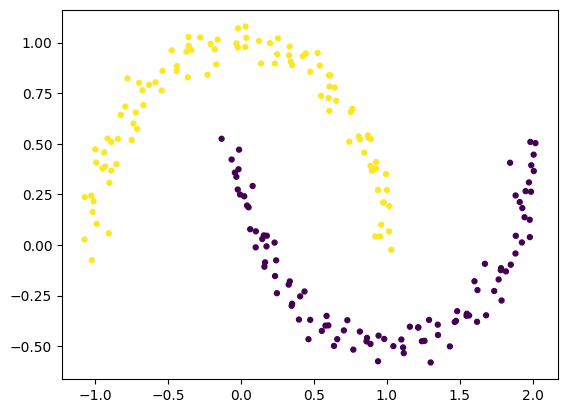

In [ ]:
from sklearn.cluster import SpectralClustering
model = SpectralClustering(n_clusters=2, affinity='nearest_neighbors',
                           assign_labels='kmeans')
labels = model.fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels,
            s=50, cmap='viridis',marker='.')
plt.show()

Cómo este método se basa en distancias, y las variables pueden tener distintas unidades, ect. Conviene Standarizar <br>
Esto lo vamos a ver la clase se sigue, por ahora vamos a decir q este procedimiento se enfoca en cambiar las escalas para hacer las variables comparables

## Métricas de evaluación para Clustering

### ¿Cómo elegir el tamaño del Cluster?

Las métricas mas extendidas en clustering son el método de Elbow y el Índice de Silueta.

El __método de Elbow__ consiste básicamente en verificar la evolución de la suma de los cuadrados del error para varias cantidades de clusters y verificar cual es el que brinda un mejor agrupamiento

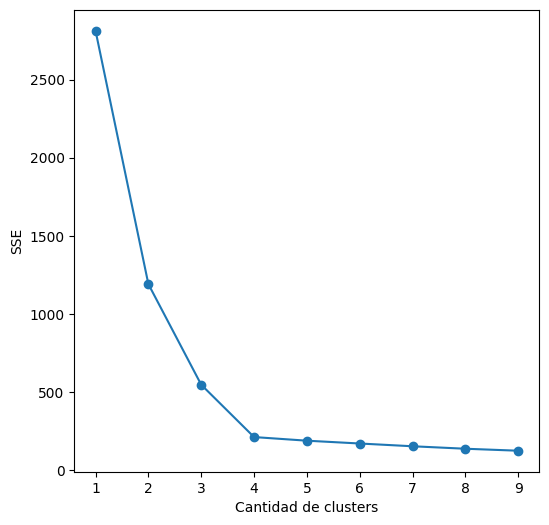

In [ ]:
# Corro el algoritmo con K entre 2 y 10 y voy guardando el error para luego graficarlo.
sse = []
list_k = list(range(1, 10))

for k in list_k:
    km = KMeans(n_clusters=k)
    km.fit(x_ejemplo1)
    sse.append(km.inertia_)

# Grafico el SSE por K
plt.figure(figsize=(6, 6))
plt.plot(list_k, sse, '-o')
plt.xlabel(r'Cantidad de clusters')
plt.ylabel('SSE')
plt.show()

Vemos que en 4 clusters la pendiente que se forma en el gráfico se quiebra, entonces vamos a probar utilizando este valor como cantidad de clusters

## Silhouette

El Índice de Silueta, como vimos en la clase teórica, indica si existen o no, estructuras en los datos.


A continuación graficamos el índice de silueta variando la cantidad de clusters de 2 a 5

In [ ]:
from sklearn.metrics import silhouette_score

list_k = list(range(2, 6))

for n_clusters in list_k:
    clusterer = KMeans(n_clusters=n_clusters)
    preds = clusterer.fit_predict(x_ejemplo1)

    score = silhouette_score (x_ejemplo1, preds)
    print ("For n_clusters =" + str(n_clusters) + " silhouette score is " + str(score))

For n_clusters =2 silhouette score is 0.5426422297358302
For n_clusters =3 silhouette score is 0.5890390393551769
For n_clusters =4 silhouette score is 0.6819938690643478
For n_clusters =5 silhouette score is 0.5923875148758644


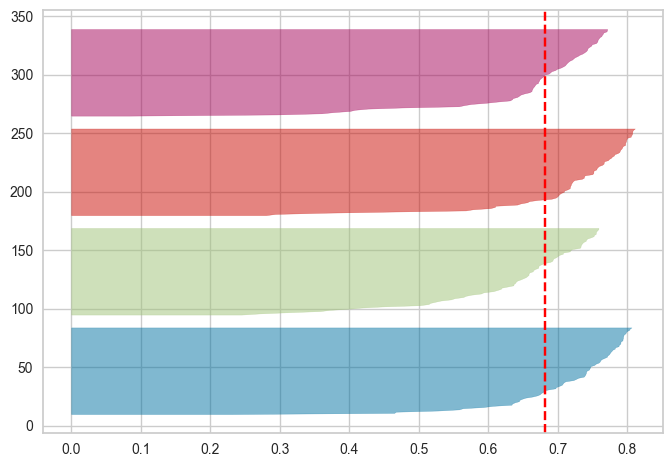

In [ ]:
from yellowbrick.cluster import SilhouetteVisualizer

model = KMeans(4, random_state=0)

# Visualizamos el gráfico de silueta
visualizer = SilhouetteVisualizer(model, colors='yellowbrick')    # Instancio el visualizador
visualizer.fit(x_ejemplo1)
plt.show()

#### Hopkins: Tendencia al clustering

In [ ]:
from pyclustertend import hopkins

hopkins(x_ejemplo1,x_ejemplo1.shape[0])

0.2009615326880733

#### Validación externa

Se cuenta con labels previos a la utilización de kmeans, y se los compara con los grupos que se armaron en kmeans

## Ejemplo 1

In [ ]:
from sklearn.datasets import load_iris

In [ ]:
iris = load_iris()
nombres_columnas=[ x.replace('(cm)','').rstrip().replace(" ","_") for x in iris['feature_names']]
df_iris=pd.DataFrame(iris['data'],columns=nombres_columnas)

y_iris=iris['target']

In [ ]:
from sklearn.preprocessing import scale, MinMaxScaler

scaler = MinMaxScaler()
df_iris_escalado = scaler.fit_transform(df_iris)

In [ ]:
kmeans = KMeans(3, random_state=0)

kmeans.fit(df_iris)

KMeans(n_clusters=3, random_state=0)

In [ ]:
clusters=kmeans.predict(df_iris)
print(clusters)

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 2 2 2 2 0 2 2 2 2
 2 2 0 0 2 2 2 2 0 2 0 2 0 2 2 0 0 2 2 2 2 2 0 2 2 2 2 0 2 2 2 0 2 2 2 0 2
 2 0]


In [ ]:
validacion_externa=pd.DataFrame(zip(y_iris,clusters),columns=['labels_reales','clusters'])
validacion_externa.head()

,labels_reales,clusters
0,0,1
1,0,1
2,0,1
3,0,1
4,0,1


In [ ]:
pd.crosstab(validacion_externa.labels_reales,validacion_externa.clusters)

clusters,0,1,2
labels_reales,,,
0,0,50,0
1,48,0,2
2,14,0,36


## Ejemplo 2

Apliquemos kmeans a compresión de imágenes
<br>  
Supongamos que tenemos una imagen con una cantidad de muy grande de colores (millones) y la queremos representar con menos.<br>
<br>
Pasos a seguir:
* Pensemos la imagen como un dataset considerando a cada pixel como una fila (una observación) <br>
* Apliquemos kmeans a los pixels, lo que generará que pixeles con colores similares estén en el mismo cluster <br>
* Luego reemplacemos cada pixel por el valor del centroide del cluster al cual pertenece

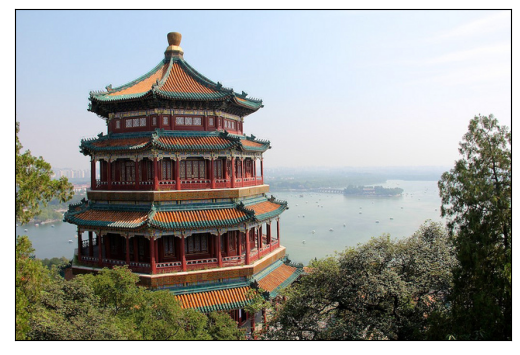

In [ ]:
from sklearn.datasets import load_sample_image

imagen_original = load_sample_image("china.jpg")
ax = plt.axes(xticks=[], yticks=[])
ax.imshow(imagen_original)
plt.show()

In [ ]:
imagen_original.shape

(427, 640, 3)

Representemos cada color como un número entre 0 y 1

In [ ]:
data = imagen_original / 255.0 # use 0...1 scale
data = data.reshape(427 * 640, 3)
data.shape

(273280, 3)

Utilicemos 16 colores para representar la imagen

In [ ]:
kmeans = KMeans(16, random_state=0)
kmeans.fit(data)
imagen_nuevos_colores = kmeans.cluster_centers_[kmeans.predict(data)]

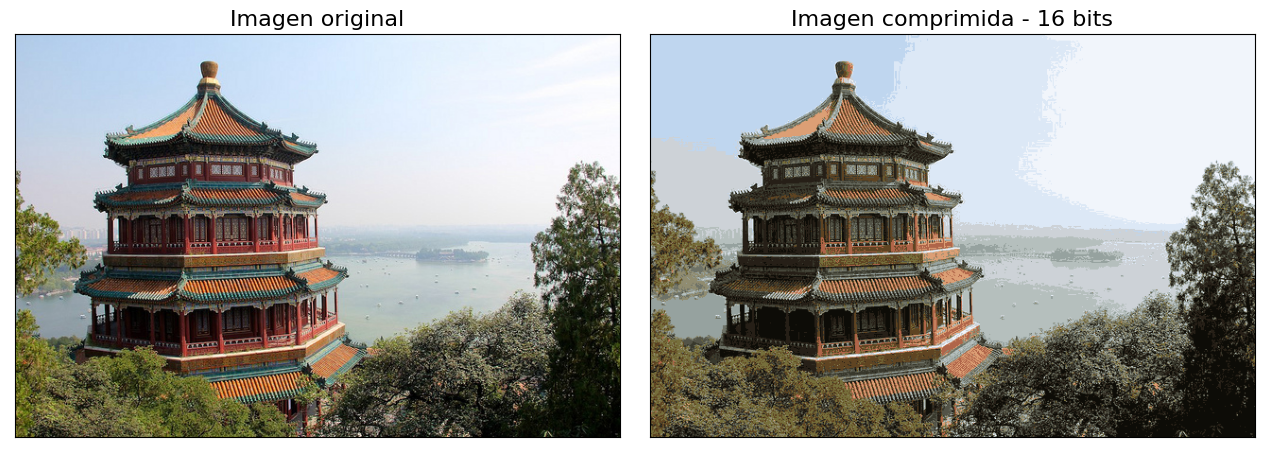

In [ ]:
imagen_comprimida = imagen_nuevos_colores.reshape(china.shape)

fig, ax = plt.subplots(1, 2, figsize=(16, 6),
                       subplot_kw=dict(xticks=[], yticks=[]))

fig.subplots_adjust(wspace=0.05)
ax[0].imshow(imagen_original)
ax[0].set_title('Imagen original', size=16)
ax[1].imshow(imagen_comprimida)
ax[1].set_title('Imagen comprimida - 16 bits', size=16)
plt.show()